In [3]:
#!pip install catboost
#!pip install category_encoders

In [4]:
import pandas as pd 
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, plot_confusion_matrix, classification_report
import time

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

import matplotlib.pyplot as plt
import seaborn as sn
from lightgbm import LGBMClassifier

In [5]:
import category_encoders as ce

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
#LOAD DATASET
data=pd.read_csv('/content/insurance.csv', header=0)
data.head(2)

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21
0,1,B,18,E,D,1295,A,B,4,B,...,B,27,C,B,2,C,1,A,A,1
1,2,D,21,C,A,2782,C,D,1,B,...,C,31,A,B,1,D,1,A,A,1


**ANALYSIS**

In [7]:
data=data.drop('Unnamed: 0', axis=1)
data.shape

(1000, 21)

*The dataset contains 1000s rows and 21 columns*

In [8]:
# CHECK FOR NULL/NAN VALUES
data.isnull().sum()

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
dtype: int64

*The dataset contains no empty cell or column*

In [9]:
#CHECK DATA TYPES FOR EACH COLUMN
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   V1      1000 non-null   object
 1   V2      1000 non-null   int64 
 2   V3      1000 non-null   object
 3   V4      1000 non-null   object
 4   V5      1000 non-null   int64 
 5   V6      1000 non-null   object
 6   V7      1000 non-null   object
 7   V8      1000 non-null   int64 
 8   V9      1000 non-null   object
 9   V10     1000 non-null   object
 10  V11     1000 non-null   int64 
 11  V12     1000 non-null   object
 12  V13     1000 non-null   int64 
 13  V14     1000 non-null   object
 14  V15     1000 non-null   object
 15  V16     1000 non-null   int64 
 16  V17     1000 non-null   object
 17  V18     1000 non-null   int64 
 18  V19     1000 non-null   object
 19  V20     1000 non-null   object
 20  V21     1000 non-null   int64 
dtypes: int64(8), object(13)
memory usage: 164.2+ KB


*The dataset contains 8 integer columns and 13 non-interger columns*

In [10]:
#CHECK DATA DISTRIBUTION FOR NUMERICAL COLUMNS
data.describe()

,V2,V5,V8,V11,V13,V16,V18,V21
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000,1.300000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086,0.458487
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


In [11]:
#DATA DISCRIPTION FOR CATEGORICAL COLUMNS
data.describe(include=object)

,V1,V3,V4,V6,V7,V9,V10,V12,V14,V15,V17,V19,V20
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,4,5,10,5,5,4,3,4,3,3,4,2,2
top,D,C,E,A,C,C,A,C,C,B,C,A,A
freq,394,530,280,603,339,548,907,332,814,713,630,596,963


*v4 has the highest number of distinct values and v20 has the occurence of A that the number of foreign companies*

Maximum value of v5 is by far higher than the rest, v2 equally has a very high maximum value These two high values will affect the value of the model, so the dataset requires scaling. Secondly, the std and mean of v5 and v2 are quite high; this again means that the distribution will be skewed. See the repercusion in the boxplot and histogram below.

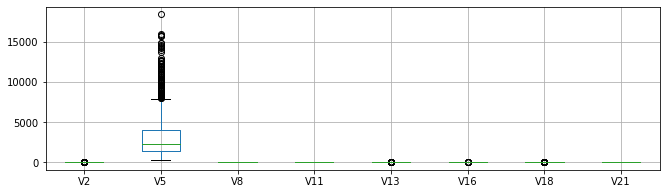

In [12]:
plt.figure(figsize=(11, 3))
data.boxplot()
plt.show()

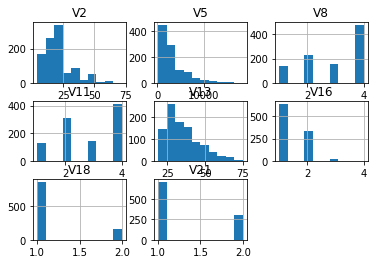

In [13]:
data.hist()
plt.show()

In [14]:
y2 = data['V21']
y2.nunique()

2

In [15]:
#CHECK THE DISRIBUTION OF VALUES IN THE TARGET COLUMN
data.V21.value_counts()

1    700
2    300
Name: V21, dtype: int64

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


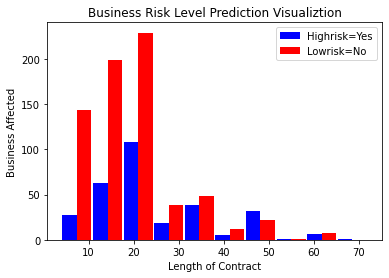

In [16]:
# PLOT BUSINESSES AFTECTED BY LENGTH OF INSURANCE CONTRACT
lowrisk = data[data.V21==1].V2
highrisk = data[data.V21==2].V2

plt.xlabel("Length of Contract")
plt.ylabel("Business Affected")
plt.title("Business Risk Level Prediction Visualiztion")

plt.hist([highrisk, lowrisk], rwidth=0.95, color=['blue','red'],label=['Highrisk=Yes','Lowrisk=No'])
plt.legend()

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


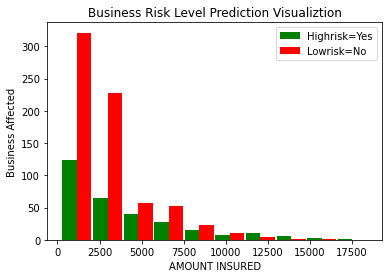

In [17]:
#BUSINESSES AFTECTED BY AMOUNT INSURED
lowrisk = data[data.V21==1].V5
highrisk = data[data.V21==2].V5

plt.xlabel("AMOUNT INSURED")
plt.ylabel("Business Affected")
plt.title("Business Risk Level Prediction Visualiztion")

plt.hist([highrisk, lowrisk], rwidth=0.95, color=['green','red'],label=['Highrisk=Yes','Lowrisk=No'])
plt.legend()

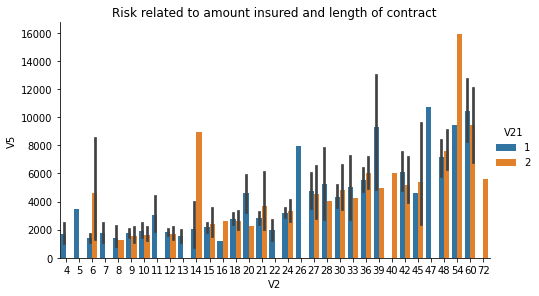

In [18]:
p = sn.catplot(x="V2", y="V5", hue="V21", kind="bar", data=data, height=4, aspect=7/4)
plt.title('Risk related to amount insured and length of contract')
plt.show()

In [19]:
# FIND CORELLATION BETWEEN VARIABLES (NUMERIC) AND TARGET
data.corrwith(data['V21'], axis=0, drop=False, method='pearson')

V2     0.214927
V5     0.154739
V8     0.072404
V11    0.002967
V13   -0.091127
V16   -0.045732
V18   -0.003015
V21    1.000000
dtype: float64

*Based on the numeric columns, v2 (Length of contract in months, has the highest impact ion the dataset) see heatmap below*

In [20]:
#DEFINE THE DIFFERENT SET OF COLUMNS WE WILL USE
cols= data.columns # all columns in dataset
number_cols = data.select_dtypes(include=np.number).columns # number colums
cat_cols= list(set(cols) - set(number_cols)) # object columns

predictors=data.iloc[:, :-1]
predictor_col=predictors.columns
predictor_col

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20'],
      dtype='object')

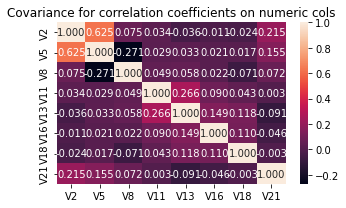

In [21]:
#USE HEATMAP TO SEE RELATIONSHIP (correlation) BETWEEN TARGET AND NUMERIC COLUMNS
plt.figure(figsize=(5, 3))
sn.heatmap(data[number_cols].corr(), annot=True, fmt='.3f', yticklabels=number_cols, xticklabels=number_cols)
plt.title('Covariance for correlation coefficients on numeric cols')
plt.tight_layout()
plt.show()

*As you can see from the heatmap, v2 (Length of contract in months, has the highest impact ion the dataset)*

**PREPROCESSING**

*First there is no null value to deal with, so we will only handle the skewness/outlier.
First Lets convert non numerc values to numeric*

In [22]:
data_conv=data

In [23]:
#ENCODE OBJECT COLUMNS TO NUMERIC
def encodes(frames):
  return(pd.factorize(frames)[0])

for colm in cat_cols:  
  data_conv[colm] = encodes(data_conv[colm])

data_conv.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21
0,0,18,0,0,1295,0,0,4,0,0,...,0,27,0,0,2,0,1,0,0,1
1,1,21,1,1,2782,1,1,1,0,0,...,1,31,1,0,1,1,1,0,0,1


In [24]:
#ENCODE OBJECT COLUMNS USING SKLEARN ENCODER
data_conv2=data

encos = ce.OrdinalEncoder(cols=cat_cols)
data_conv2[cat_cols]=encos.fit_transform(data_conv2[cat_cols])
data_conv2.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21
0,1,18,1,1,1295,1,1,4,1,1,...,1,27,1,1,2,1,1,1,1,1
1,2,21,2,2,2782,2,2,1,1,1,...,2,31,2,1,1,2,1,1,1,1


In [25]:
#FIND RELATIONSHIP BETWEEN COLUMNS AND TARGET VARIABLE
data_conv.corrwith(data['V21'], axis=0, drop=False, method='pearson')

V1     0.145605
V2     0.214927
V3     0.236953
V4     0.013102
V5     0.154739
V6    -0.165964
V7    -0.022684
V8     0.072404
V9    -0.084416
V10   -0.025137
V11    0.002967
V12    0.034011
V13   -0.091127
V14    0.104885
V15    0.127789
V16   -0.045732
V17   -0.000498
V18   -0.003015
V19   -0.036466
V20   -0.082079
V21    1.000000
dtype: float64

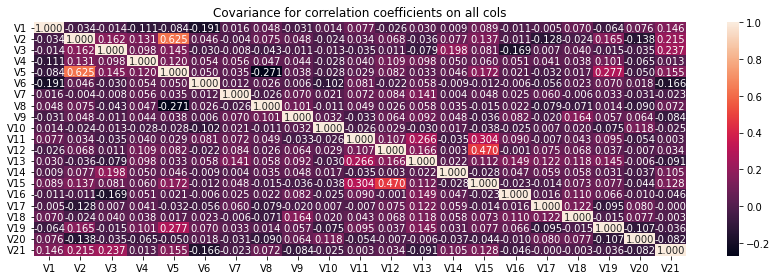

In [26]:
#USE HEATMAP TO SEE RELATIONSHIP (correlation) BETWEEN TARGET AND NUMERIC COLUMNS
plt.figure(figsize=(12, 4))
sn.heatmap(data_conv.corr(), annot=True, fmt='.3f', yticklabels=cols, xticklabels=cols)
plt.title('Covariance for correlation coefficients on all cols')
plt.tight_layout()
plt.show()

*After enconding, the dataset still shows v2 (Length of contract in months) as well as v3 (Credit history) as having the highest impact In asddition, v2 is highly corelated with v5 (Sum insured) and v12 (Property) is correlated with v15. Whereas, V17, : Business line, has the lowest negative impact.*

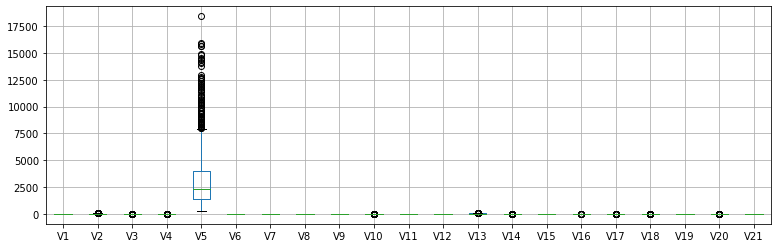

In [27]:
#MAKING A BOXPLOT OF ALL THE COLUMNS
plt.figure(figsize=(13, 4))
data_conv.boxplot()
plt.show()

In [28]:
#FINALLY, WE CHECK UNIVALUES FOR ALL COLUMNS
def ucols(datas):
       for col in datas:
            if datas[col].dtypes=='object':
               print(f'{col}: {data[col].unique()}') 

ucols(data)

In [29]:
def ucols2(datas):
       for col in datas:
            print(f'{col}: {data[col].unique()}') 

ucols2(data_conv[cat_cols])

V4: [ 1  2  3  4  5  6  7  8  9 10]
V15: [1 2 3]
V9: [1 2 3 4]
V10: [1 2 3]
V7: [1 2 3 4 5]
V17: [1 2 3 4]
V6: [1 2 3 4 5]
V14: [1 2 3]
V12: [1 2 3 4]
V3: [1 2 3 4 5]
V1: [1 2 3 4]
V20: [1 2]
V19: [1 2]


**BUILDIING THE MODEL**

In [30]:
#DEFINE X AND Y
x = data_conv[predictor_col]
x2=data_conv2[predictor_col] #x  from the cat-encoder-encoded data
y = data['V21'].values

In [ ]:
mainy=pd.factorize(y)[0]
mainy

In [32]:
#UPSAMPLING THE MINORITY TARGET VALUE
def resamp(data_conv):
  from sklearn.utils import resample
  # Create Maj, Min class
  data_maj = data_conv[data_conv.V21==1]
  data_min = data_conv[data_conv.V21==2]
  
  # Upsample minority class
  data_mim_up = resample(data_min, replace=True, n_samples=500,  random_state=123)
  data_up = pd.concat([data_maj , data_mim_up])
  data_up.V21.value_counts()
  print(data_up)
  return(data_up)

ndata=resamp(data_conv)

     V1  V2  V3  V4    V5  V6  V7  V8  V9  V10  ...  V12  V13  V14  V15  V16  \
0     1  18   1   1  1295   1   1   4   1    1  ...    1   27    1    1    2   
1     2  21   2   2  2782   2   2   1   1    1  ...    2   31    2    1    1   
2     3   9   2   3  1126   3   3   2   2    1  ...    3   49    1    1    1   
4     4  10   1   2  1038   1   2   4   3    2  ...    1   49    1    1    2   
5     4  24   1   4  2957   1   3   4   3    1  ...    1   63    1    1    2   
..   ..  ..  ..  ..   ...  ..  ..  ..  ..  ...  ...  ...  ...  ...  ...  ...   
112   4  12   2   9   741   3   5   4   1    1  ...    1   22    1    1    1   
824   4  48   1   4  6143   1   3   4   1    1  ...    4   58    3    3    2   
419   4  30   2   1  6350   4   3   4   3    1  ...    1   31    1    1    1   
824   4  48   1   4  6143   1   3   4   1    1  ...    4   58    3    3    2   
882   1  12   2   2   685   1   2   2   4    1  ...    2   25    2    1    1   

     V17  V18  V19  V20  V21  
0      1

In [33]:
#DEFINE X AND Y
nx = ndata[predictor_col]
ny = ndata['V21'].values

In [34]:
ny=pd.factorize(ny)[0]
ny

array([0, 0, 0, ..., 1, 1, 1])

In [38]:
# Normalize Features
sc= StandardScaler()
s=sc.fit(x, mainy)
xs= s.fit_transform(x)
xss= s.fit_transform(nx)
#xs2=s.fit_transform(x2)

rs= RobustScaler()
r=rs.fit(x, mainy)
xr = r.fit_transform(x)
xrr = r.fit_transform(nx)

In [36]:
from sklearn.model_selection import train_test_split
xtrain, xeval, ytrain, yeval=train_test_split(xs, mainy, test_size=0.3, random_state=23)
xtrain2, xeval2, ytrain2, yeval2=train_test_split(xr, mainy, test_size=0.3, random_state=23)
xtrain4, xeval4, ytrain4, yeval4=train_test_split(xss, ny, test_size=0.3, random_state=23)
xtrain5, xeval5, ytrain5, yeval5=train_test_split(xrr, ny, test_size=0.3, random_state=23)
xf, xtf, yf, ytf=train_test_split(x.values, mainy, test_size=0.3, random_state=23)

In [40]:
#xf2, xtf2, yf2, ytf2=train_test_split(xs2.values, mainy, test_size=0.3, random_state=23)

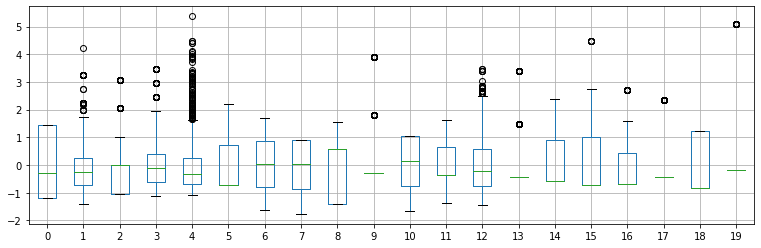

In [41]:
#MAKING A BOXPLOT OF ALL THE COLUMNS After scaling (standardscaler)
xtrainp=pd.DataFrame(data=xs)
plt.figure(figsize=(13, 4))
xtrainp.boxplot()
plt.show()

In [ ]:
#robustscaler
xtrainp2=pd.DataFrame(data=xr)
plt.figure(figsize=(13, 4))
xtrainp2.boxplot()
plt.show()

In [42]:
#START WITH THE BASELINE MODELS (TESTING 8 MODELS)
classifiers=[GradientBoostingClassifier(),GaussianNB(), DecisionTreeClassifier(),MLPClassifier(max_iter=1000), 
KNeighborsClassifier(), RandomForestClassifier(), CatBoostClassifier(logging_level='Silent'), 
LogisticRegression(max_iter=2000), XGBClassifier(random_state = 0, use_label_encoder=False, eval_metric='logloss'), 
LGBMClassifier(), BernoulliNB(), AdaBoostClassifier(), SVC(gamma=2, C=1)]

In [43]:
#DEFINE FUNCTION TO RUN THE MODELS
from sklearn.metrics import mean_squared_error
def modeld(classifiers, X_train, y_train, X_test, y_test): 
    model_lisdt=[]     
    for classers in classifiers:        
        t1=time.time()
        classify=classers
        classify = classify.fit(X_train, y_train)
        model_lisdt.append(classify)
        time_taken = time.time() - t1
        
        predicted=classify.predict(X_test)        
        st=str(classers)
                    
        print(' \n ############## {} ################'.format(st))
        print(" Duration =:\t {}".format(time_taken))
        print(" Accuracy =: \t {:0.2f} %".format(accuracy_score(y_test, predicted)*100))         
        print(" ROC_AUC =: \t {:0.2f} %".format(roc_auc_score(y_test, predicted) *100))  
        print(" F1 SCORE =: \t {:0.2f} %".format(f1_score(y_test, predicted, average='weighted') *100))
        print(" MSE ERROR =: \t", mean_squared_error(y_test,predicted) *100, "\t%") 
    return(model_lisdt)

In [44]:
#TESTING THE STANDARDISED DATASET
standarsised_full=modeld(classifiers, xtrain,ytrain,xeval,yeval)

 
 ############## GradientBoostingClassifier() ################
 Duration =:	 0.18568015098571777
 Accuracy =: 	 76.67 %
 ROC_AUC =: 	 67.59 %
 F1 SCORE =: 	 75.42 %
 MSE ERROR =: 	 23.333333333333332 	%
 
 ############## GaussianNB() ################
 Duration =:	 0.004721164703369141
 Accuracy =: 	 69.67 %
 ROC_AUC =: 	 64.36 %
 F1 SCORE =: 	 70.00 %
 MSE ERROR =: 	 30.333333333333336 	%
 
 ############## DecisionTreeClassifier() ################
 Duration =:	 0.007439136505126953
 Accuracy =: 	 71.33 %
 ROC_AUC =: 	 64.51 %
 F1 SCORE =: 	 71.13 %
 MSE ERROR =: 	 28.666666666666668 	%
 
 ############## MLPClassifier(max_iter=1000) ################
 Duration =:	 5.153512001037598
 Accuracy =: 	 69.67 %
 ROC_AUC =: 	 61.30 %
 F1 SCORE =: 	 69.02 %
 MSE ERROR =: 	 30.333333333333336 	%
 
 ############## KNeighborsClassifier() ################
 Duration =:	 0.0008008480072021484
 Accuracy =: 	 72.00 %
 ROC_AUC =: 	 59.20 %
 F1 SCORE =: 	 69.02 %
 MSE ERROR =: 	 28.000000000000004 	%
 
 #

 ############## LGBMClassifier() ################
 Duration =:	 0.06352019309997559
 Accuracy =: 	 77.00 %
 ROC_AUC =: 	 67.48 %
 F1 SCORE =: 	 75.57 %
 MSE ERROR =: 	 23.0 	%

In [ ]:
robust_full=modeld(classifiers, xtrain2,ytrain2,xeval2,yeval2)

############## LGBMClassifier() ################
 Duration =:	 0.061649322509765625
 Accuracy =: 	 77.33 %
 ROC_AUC =: 	 68.40 %
 F1 SCORE =: 	 76.12 %
 MSE ERROR =: 	 22.666666666666664 	%

In [ ]:
rs_full=modeld(classifiers, xtrain4,ytrain4,xeval4,yeval4)#Resampled + standarded

 
  ############## RandomForestClassifier() ################
 Duration =:	 0.23058009147644043
 Accuracy =: 	 88.06 %
 ROC_AUC =: 	 87.69 %
 F1 SCORE =: 	 88.05 %
 MSE ERROR =: 	 11.944444444444445 	%
 
 
 
 ############## SVC(C=1, gamma=2) ################
 Duration =:	 0.04724311828613281
 Accuracy =: 	 89.72 %
 ROC_AUC =: 	 87.75 %
 F1 SCORE =: 	 89.42 %
 MSE ERROR =: 	 10.277777777777777 	%

In [ ]:
rr_full=modeld(classifiers, xtrain5,ytrain5,xeval5,yeval5)#Resampled + robust

  ############## RandomForestClassifier() ################
 Duration =:	 0.23780035972595215
 Accuracy =: 	 87.22 %
 ROC_AUC =: 	 87.07 %
 F1 SCORE =: 	 87.24 %
 MSE ERROR =: 	 12.777777777777777 	%

 
 
 ############## SVC(C=1, gamma=2) ################
 Duration =:	 0.04800581932067871
 Accuracy =: 	 89.72 %
 ROC_AUC =: 	 87.75 %
 F1 SCORE =: 	 89.42 %
 MSE ERROR =: 	 10.277777777777777 	%

In [ ]:
f_full=modeld(classifiers, xf,yf,xtf,ytf)#unsampled full

 ############## LGBMClassifier() ################
 Duration =:	 0.06250810623168945
 Accuracy =: 	 77.00 %
 ROC_AUC =: 	 67.48 %
 F1 SCORE =: 	 75.57 %
 MSE ERROR =: 	 23.0 	%

In [ ]:
enc_std=modeld(classifiers, xf2, yf2, xtf2, ytf2) #enc coded data

 ############## <catboost.core.CatBoostClassifier object at 0x7efdcf700310> ################
 Duration =:	 1.1473736763000488
 Accuracy =: 	 76.33 %
 ROC_AUC =: 	 65.99 %
 F1 SCORE =: 	 74.57 %
 MSE ERROR =: 	 23.666666666666668 	%

*Most of the models perfomed well on the STANDARDISED and ROBUST-SCALED resampled dataset, but we selected (randomforest) and catboost to optimize on  standardised dataset*

In [45]:
modeld=standarsised_full[5]
modeld

RandomForestClassifier()

In [46]:
model2=standarsised_full[6]
model2

In [47]:
ypred3=modeld.predict(xeval)

In [48]:
ypred4=model2.predict(xeval)

In [49]:
cm=confusion_matrix(yeval, ypred3)
cm

array([[192,  21],
       [ 53,  34]])

In [50]:
cm2=confusion_matrix(yeval, ypred4)
cm2

array([[193,  20],
       [ 51,  36]])

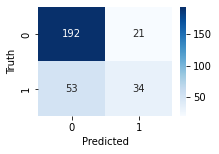

In [51]:
plt.figure(figsize=(3, 2))
sn.heatmap(cm, annot=True, fmt="d",cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

**SELECT CATBOOST MODEL, EVALUATE AND OPTIMIZE**

In [52]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

In [53]:
#RF
cvs = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(modeld, xtrain, ytrain, scoring='accuracy', cv=cvs, n_jobs=-1)
print('Validation Accuracy and std =:\t %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Validation Accuracy and std =:	 0.749 (0.049)


In [54]:
#CATBOOST
scores = cross_val_score(model2, xtrain, ytrain, scoring='accuracy', cv=cvs, n_jobs=-1)
print('Validation Accuracy and std =:\t %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Validation Accuracy and std =:	 0.766 (0.056)


In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

grid = {'iterations': [10, 30, 50],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
        
best_model= GridSearchCV(model2, grid,  cv=cvs,  n_jobs=1, error_score='raise', scoring = 'roc_auc') 
best_model.fit(xtrain, ytrain)   
acc= best_model.score(xeval, yeval) 
print('OPTIMISED MODEL ACCURACY =: \t{:0.2f}'.format(acc))

OPTIMISED MODEL ACCURACY =: 	0.76


In [58]:
best_model.best_params_

{'depth': 8, 'iterations': 50, 'l2_leaf_reg': 3, 'learning_rate': 0.03}

In [56]:
#OPTIMIZE RF
grid2 = {'criterion': ['gini','entropy'],
        'max_depth': [2,3,6,10, 20],
        'max_features': ['log2', 'sqrt'],
        'min_samples_leaf': [1,3,5],
        'min_samples_split': [2,3,5],
        'min_weight_fraction_leaf': [0.0],
        'n_estimators': [10, 20],       
        'n_jobs': [1],'random_state':[42]}
        
best_model2= GridSearchCV(modeld, grid2,  cv=cvs,  n_jobs=1, error_score='raise', scoring = 'roc_auc') 
best_model2.fit(xtrain, ytrain)   
acc2= best_model.score(xeval, yeval) 
print('OPTIMISED MODEL ACCURACY =: \t{:0.2f}'.format(acc2))

OPTIMISED MODEL ACCURACY =: 	0.76


In [57]:
best_model2.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'log2',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 20,
 'n_jobs': 1,
 'random_state': 42}

**WITH ANN**

In [ ]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(20, input_shape=(20,), activation='relu'),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(xtrain, ytrain, epochs=100)# Using balanced dataset

#es_callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5,  restore_best_weights=True,verbose=1)
#models.fit(xtrain, ytrains,callbacks=es_callback, epochs=50)

In [ ]:
model.evaluate(xeval,yeval)

In [ ]:
preds=model.predict(xeval)
preds

In [ ]:
y_predt = []
for el in preds:
    if el > 0.5:
        y_predt.append(1)
    else:
        y_predt.append(0)

In [ ]:
cm4 = tf.math.confusion_matrix(labels=yeval, predictions=y_predt)
cm4

In [ ]:
plt.figure(figsize=(3, 2))
sn.heatmap(cm4, annot=True, fmt="d",cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

**LOADING THE CORRUPTED DATASET**

In [59]:
cdata=pd.read_csv('/content/corrupted.csv', header=0)
cdata.head(2)

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
0,1,B,18.0,E,NaN,1295.0,A,B,4.0,B,...,1.0,B,27.0,C,B,2.0,C,1.0,A,A
1,2,D,21.0,C,A,2782.0,C,D,1.0,B,...,2.0,C,31.0,A,B,1.0,D,1.0,A,A


In [60]:
cdata=cdata.drop('Unnamed: 0', axis=1)
cdata.shape

(1000, 20)

In [ ]:
#Checking for missing values
cdata.isnull().sum()

All the columns has missing values

In [ ]:
colours = ['#000099', '#ffff00'] 
sn.heatmap(cdata.isnull(), cmap=sn.color_palette(colours))
plt.show()
#Yellow shows the missind/NaN cells

In [ ]:
#CHECK PERCENTAGE MISSINESS
for coll in cdata.columns:
    mis= (cdata[coll].isnull().sum())/len(cdata[coll])
    print('{} - {}%'.format(coll, round(mis*100)))

In [61]:
#ELIMINATE AUTOMATICALLY VARIABLES WITH MORE THAN 20% OF MISSINGNESS
cdatas= cdata[cdata.columns[cdata.isnull().sum() > 0.1]]
cdatas.shape

(1000, 20)

*All 20 columns contain at least 10% missing value, but less than 20%, so we fill them rather than remove the columns*

In [62]:
#1. FIRST, WE USE PANDAS INTERPOLATE TO INTERPOLATE MISSING CELLS
cdatas=cdatas.interpolate(method='pad')

In [ ]:
cdatas.isnull().sum()

In [64]:
#2. WE USE BACKWARDS FILL TO FILL THE REMAIN 1 SINGLE CELL
cdatas.V4=cdatas.V4.fillna(method='bfill')
cdatas.head(3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
0,B,18.0,E,A,1295.0,A,B,4.0,B,A,1.0,B,27.0,C,B,2.0,C,1.0,A,A
1,D,21.0,C,A,2782.0,C,D,1.0,B,A,2.0,C,31.0,A,B,1.0,D,1.0,A,A
2,D,9.0,C,E,1126.0,B,E,2.0,A,A,4.0,A,49.0,C,B,1.0,C,1.0,A,A


In [65]:
#THEN WE FACTORISE CATEGORICAL COLUMNS
#ENCODE OBJECT COLUMNS TO NUMERIC
for colL in cat_cols:  
  cdatas[colL] = encodes(cdatas[colL])

cdatas.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
0,0,18.0,0,0,1295.0,0,0,4.0,0,0,1.0,0,27.0,0,0,2.0,0,1.0,0,0
1,1,21.0,1,0,2782.0,1,1,1.0,0,0,2.0,1,31.0,1,0,1.0,1,1.0,0,0


In [66]:
xnewdata=s.fit_transform(cdatas)
xnewdata

array([[-1.28016892, -0.23355223, -1.0505614 , ..., -0.42665337,
        -0.80295507, -0.18473268],
       [-0.16211746,  0.01605828, -0.03257555, ..., -0.42665337,
        -0.80295507, -0.18473268],
       [-0.16211746, -0.98238374, -0.03257555, ..., -0.42665337,
        -0.80295507, -0.18473268],
       ...,
       [-0.16211746,  0.01605828, -0.03257555, ...,  2.34382305,
        -0.80295507, -0.18473268],
       [-1.28016892, -0.48316273,  2.00339616, ..., -0.42665337,
        -0.80295507, -0.18473268],
       [ 0.955934  ,  0.26566878,  2.00339616, ..., -0.42665337,
        -0.80295507, -0.18473268]])

In [67]:
#THEN WE USE THE CHOSEN MODEL TO PREDICT THE MISSING COLUMN
f_model=best_model2.best_estimator_
ypred5=f_model.predict(xnewdata)

In [68]:
print(" val_Accuracy =: \t {:0.2f} %".format(accuracy_score(mainy, ypred5)*100))         

 val_Accuracy =: 	 63.80 %


In [69]:
#TRYING ON UNSCALLED DATASET
ypred6=f_model.predict(cdatas.values)

In [70]:
print(" val_Accuracy =: \t {:0.2f} %".format(accuracy_score(mainy, ypred6)*100))

 val_Accuracy =: 	 48.70 %


In [ ]:
cm5=confusion_matrix(mainy, ypred5)
cm5

In [ ]:
plt.figure(figsize=(3, 2))
sn.heatmap(cm5, annot=True, fmt="d",cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [71]:
#3. TRYING ZERO FILL
cdatas2= cdata[cdata.columns[cdata.isnull().sum() > 0.1]]
cdatas2.shape

(1000, 20)

In [ ]:
cdatas2=cdatas2.fillna(0)
cdatas2.isnull().sum()

In [73]:
#THEN WE FACTORISE CATEGORICAL COLUMNS
#ENCODE OBJECT COLUMNS TO NUMERIC
for colL in cat_cols:  
  cdatas2[colL] = encodes(cdatas2[colL])

cdatas2.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20
0,0,18.0,0,0,1295.0,0,0,4.0,0,0,1.0,0,27.0,0,0,2.0,0,1.0,0,0
1,1,21.0,1,1,2782.0,1,1,1.0,0,0,2.0,1,31.0,1,0,1.0,1,1.0,0,0


In [ ]:
xnewdata2=s.fit_transform(cdatas2)
xnewdata2

In [75]:
ypred7=f_model.predict(xnewdata2)

In [76]:
print(" val_Accuracy =: \t {:0.2f} %".format(accuracy_score(mainy, ypred7)*100))   

 val_Accuracy =: 	 65.20 %


In [ ]:
cm7=confusion_matrix(mainy, ypred7)
cm7

In [ ]:
plt.figure(figsize=(3, 2))
sn.heatmap(cm5, annot=True, fmt="d",cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [79]:
#4. TRYING ENCODING PLUS INTERPOLATING FILLIN METHOD
cdatas3= cdata[cdata.columns[cdata.isnull().sum() > 0.1]]

In [ ]:
cdatas3.isnull().sum()

In [78]:
catcol=cdata.select_dtypes(object).columns
ncol=list(set(cdatas3.columns)-set(catcol))

In [ ]:
#FIRST WE USE AUTO-ENCODER ENCODING TO ENCODE CATEGORICAL DATA COLUMNS
enco = ce.OrdinalEncoder(cols=catcol)
cdatas3[catcol]=enco.fit_transform(cdatas3[catcol])
cdatas3.head(2)

In [ ]:
#WE USE INTERPOLATE TO FILL NUMEROCAL MISSING VALUES
cdatas3[ncol]=cdatas3[ncol].interpolate(method='pad')
cdatas3.head(2)

In [ ]:
#THEN WE USED THE STANDARDSCALER TO SCALE
xnewdata3=s.fit_transform(cdatas3)
xnewdata3

In [84]:
#ypred8=f_model.predict(xnewdata3)
yp=model2.predict(xnewdata3)

In [85]:
print(" val_Accuracy =: \t {:0.2f} %".format(accuracy_score(mainy, yp)*100))   

 val_Accuracy =: 	 63.70 %


In [91]:
#5. FILLING NUMERICAL COLUMN WITH MEAN
cdatas4= cdata[cdata.columns[cdata.isnull().sum() > 0.1]]

In [ ]:
cdatas4[catcol]=enco.fit_transform(cdatas4[catcol])
cdatas4.head(2)

In [ ]:
#WE USE MEAN OF NUMBER COLUMN TO FILL NUMEROCAL MISSING VALUES
cdatas4[ncol]=cdatas4[ncol].fillna(cdatas4[ncol].mean())
cdatas4.head(2)

In [ ]:
#THEN WE USED THE STANDARDSCALER TO SCALE
xnewdata4=s.fit_transform(cdatas4)
xnewdata4

In [95]:
#ypred8=f_model.predict(xnewdata3)
yp1=model2.predict(xnewdata4)
print(" val_Accuracy =: \t {:0.2f} %".format(accuracy_score(mainy, yp1)*100))  

 val_Accuracy =: 	 64.10 %


In [ ]:
cdatas3['V21']=ypred7
cdatas3

In [ ]:
cdatas3.to_csv("final_corrupted.csv", index=0)

In [ ]:
###########    USING THE MODEL
def use_Model(arr):
   #from sklearn.preprocessing import StandardScaler
   #ss=StandardScaler()   
   sett=s.fit_transform(arr)   
   predict= f_model.predict(sett)

   if (predict==0):
      print('Congratulations, your business is not at risk')
   else:
      print('Sorry, your business is at a great risk, You need to incvrease your insured amount')
      
print('ENTER DETAILS TO CHECK STATUS')
use_Model(['INSERT ARRAY NEW INSURANCE DATA'])

In [ ]:
import joblib
# save the model to disk
f_name = 'InsuranceRisk_checker.sav'
joblib.dump(f_model, f_name)

In [ ]:
newx=[[]]      
# load the model from disk
saved_model = joblib.load(f_name)
new_model = saved_model.predict([[newx]])
#result = saved_model.score(newx, newy)
#print(result)